---
title: Stable diffusion using 🤗 Hugging Face - Putting everything together.
author: Aayush Agrawal
date: "2022-11-07"
categories: [Stable Diffusion]
image: "building-blocks-vector-28.jpg"
format:
    html:
        code-fold: false
        number-sections: true
---

> An introduction to the diffusion process using  🤗 [hugging face diffusers library](https://github.com/huggingface/diffusers).

This is my third post of the Stable diffusion series, if you haven't checked out the first one, you can read it here - <br>
1. **Part 1** - [Stable diffusion using 🤗 Hugging Face - Introduction](https://aayushmnit.com/posts/2022-11-02-StabeDiffusionP1/2022-11-02-StableDiffusionP1.html). <br>
2. **Part 2** - [Stable diffusion using 🤗 Hugging Face - Looking under the hood](https://aayushmnit.com/posts/2022-11-05-StableDiffusionP2/2022-11-05-StableDiffusionP2.html). <br>

In previous posts, I went over showing how to install 🤗 diffuser library to start generating your own AI images and key components of the stable diffusion pipeline i.e., CLIP text encoder, VAE, and U-Net. In this post, we will try to put these key components together and do a walk-through of the diffusion process which generates the image. 

<figure>
<img src="./building-blocks-vector-28.jpg" style="width:100%">
<figcaption align = "center">
        Fig. 1: <a href="https://vectorified.com/building-blocks-vector">Building Blocks Vector</a>
</figcaption>
</figure>

## Overview - The Diffusion Process

The stable diffusion model takes the textual input and a seed. The textual input is then passed through the CLIP model to generate textual embedding of size 77x768 and the seed is used to generate  Gaussian noise of size 4x64x64 which becomes the first latent image representation.

:::{.callout-note}
You will notice that there is an additional dimension mentioned (1x) in the image like 1x77x768 for text embedding, that is because it represents the batch size of 1.
:::

<figure>
<img src="./diffusion_image.png" style="width:100%">
<figcaption align = "center">
        Fig. 2: The diffusion process.
</figcaption>
</figure>

Next, the U-Net iteratively denoises the random latent image representations while conditioning on the text embeddings. The output of the U-Net is predicted noise residual, which is then used to compute conditioned latents via a scheduler algorithm. This process of denoising and text conditioning is repeated N times (We will use 50) to retrieve a better latent image representation. Once this process is complete, the latent image representation (4x64x64) is decoded by the VAE decoder to retrieve the final output image (3x512x512). 

:::{.callout-note}
This iterative denoising is an important step for getting a good output image. Typical steps are in the range of 30-80. However, there are [recent papers](https://arxiv.org/abs/2202.00512) that claim to reduce it to 4-5 steps by using distillation techniques.
:::

## Understanding the diffusion process through code

Let's start by importing the required libraries and helper functions. All of this was already used and explained in the previous [part 2 of the series](https://aayushmnit.com/posts/2022-11-05-StableDiffusionP2/2022-11-05-StableDiffusionP2.html). 

In [1]:
#| code-fold: false
import torch, logging

## disable warnings
logging.disable(logging.WARNING)  

## Imaging  library
from PIL import Image
from torchvision import transforms as tfms

## Basic libraries
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline

## Import the CLIP artifacts 
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler

## Initiating tokenizer and encoder.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to("cuda")

## Initiating the VAE
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", torch_dtype=torch.float16).to("cuda")

## Initializing a scheduler and Setting number of sampling steps
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
scheduler.set_timesteps(50)

## Initializing the U-Net model
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16).to("cuda")

## Helper functions
def load_image(p):
    '''
    Function to load images from a defined path
    '''
    return Image.open(p).convert('RGB').resize((512,512))

def pil_to_latents(image):
    '''
    Function to convert image to latents
    '''
    init_image = tfms.ToTensor()(image).unsqueeze(0) * 2.0 - 1.0
    init_image = init_image.to(device="cuda", dtype=torch.float16) 
    init_latent_dist = vae.encode(init_image).latent_dist.sample() * 0.18215
    return init_latent_dist

def latents_to_pil(latents):
    '''
    Function to convert latents to images
    '''
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

def text_enc(prompts, maxlen=None):
    '''
    A function to take a texual promt and convert it into embeddings
    '''
    if maxlen is None: maxlen = tokenizer.model_max_length
    inp = tokenizer(prompts, padding="max_length", max_length=maxlen, truncation=True, return_tensors="pt") 
    return text_encoder(inp.input_ids.to("cuda"))[0].half()

The code below is a stripped-down version of what is present in the [`StableDiffusionPipeline.from_pretrained`](https://github.com/huggingface/diffusers/blob/269109dbfbbdbe2800535239b881e96e1828a0ef/src/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py) function to show the important parts of the diffusion process. 

In [7]:
def mk_img(prompts, g=7.5, seed=100, steps=70, dim=512):
    """
    Diffusion process to convert prompt to image
    """
    
    # Defining batch size
    bs = len(prompts) 
    
    # Converting textual prompts to embedding
    text = text_enc(prompts) 
    
    # Adding an unconditional prompt , helps in the generation process
    uncond =  text_enc([""] * bs, text.shape[1])
    emb = torch.cat([uncond, text])
    
    # Setting the seed
    if seed: torch.manual_seed(seed)
    
    # Initiating random noise
    latents = torch.randn((bs, unet.in_channels, dim//8, dim//8))
    
    # Setting number of steps in scheduler
    scheduler.set_timesteps(steps)
    
    # Adding noise to the latents 
    latents = latents.to("cuda").half() * scheduler.init_noise_sigma
    
    # Iterating through defined steps
    for i,ts in enumerate(tqdm(scheduler.timesteps)):
        # We need to scale the i/p latents to match the variance
        inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
        
        # Predicting noise residual using U-Net
        with torch.no_grad(): u,t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)
            
        # Performing Guidance
        pred = u + g*(t-u)
        
        # Conditioning  the latents
        latents = scheduler.step(pred, ts, latents).prev_sample
    
    # Returning the latent representation to output an image of 3x512x512
    return latents_to_pil(latents)

Let's see if the function works as intended.

  0%|          | 0/70 [00:00<?, ?it/s]

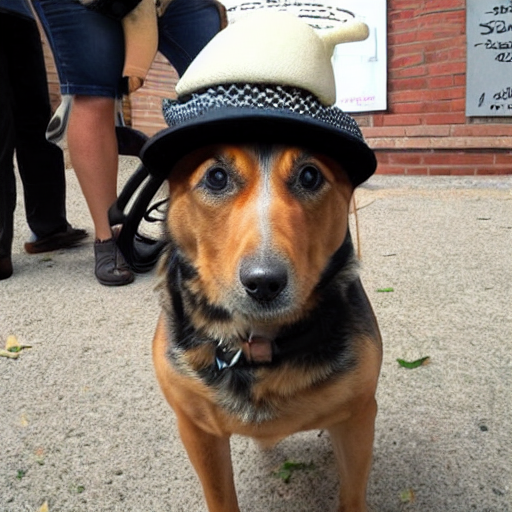

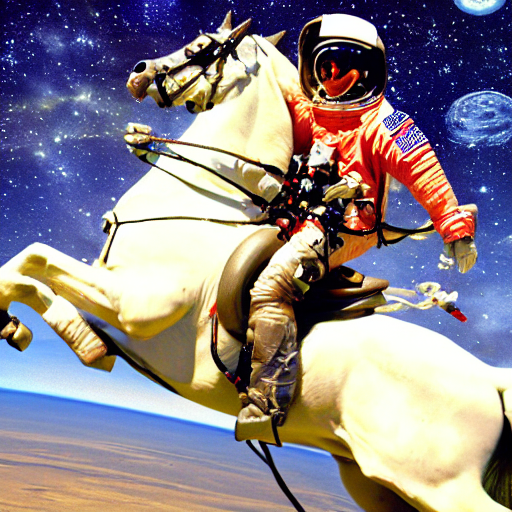

In [11]:
images = mk_img(["A dog wearing a hat", "a photograph of an astronaut riding a horse"])
for img in images:display(img)

Looks like it is working! So let's take a deeper dive at the hyper-parameters of the function. <br>
1. `prompt` - this is the textual prompt we pass through to generate an image. Similar to the `pipe(prompt)` function we saw in part 1 <br>
2. `g` or `guidance scale ` -  It's a value that determines how close the image should be to the textual prompt. This is related to a technique called [Classifier free guidance](https://benanne.github.io/2022/05/26/guidance.html) which improves the quality of the images generated. The higher the value of the guidance scale, more close it will be to the textual prompt <br>
3. `seed` - This sets the seed from which the initial Gaussian noisy latents are generated <br>
4. `steps` - Number of de-noising steps taken for generating the final latents. <br>
5. `dim` - dimension of the image, for simplicity we are currently generating square images, so only one value is needed <br>

## Conclusion

I hope this gives a good overview and breaks the code to the bare minimum so that we can understand each component. Now that we have the minimum code implemented, in the next post we will see make some tweaks to the `mk_img` function to add additional functionality i.e., img2img pipeline and negative prompt.

I hope you enjoyed reading it, and feel free to use my code and try it out for generating your images. Also, if there is any feedback on the code or just the blog post, feel free to reach out on [LinkedIn](https://www.linkedin.com/in/aayushmnit/) or email me at aayushmnit@gmail.com.

## References

- [Fast.ai course - 1st Two Lessons of From Deep Learning Foundations to Stable Diffusion](https://www.fast.ai/posts/part2-2022-preview.html)
- [Stable Diffusion with 🧨 Diffusers](https://huggingface.co/blog/stable_diffusion)
- [Getting Started in the World of Stable Diffusion](https://bipinkrishnan.github.io/posts/getting-started-in-the-world-of-stable-diffusion/)
